In [1]:
%%capture
!pip3 install -r requirements.txt

## Arquitecture

# Training and Using a Discriminator

The discriminator was trained on a separate script because it took some time. It was trained like this:


``` python
    full_train_discriminator = Discriminator()
    folders = ["inpainting", "insight","text2img"]
    for name in folders:
        train_df, test_df = get_train_test(real="data/wiki/", fake=f"data/{name}/")
        
        print(f"\nTraining full Discriminator:")
        full_train_discriminator.fit(train_df, val_split=0.2, epochs=2, batch_size=BATCH_SIZE, lr=0.0002)
        
        print(f"\nTraining Discriminator: '{name}'")
        single_train_discriminator = Discriminator()
        single_train_discriminator.fit(train_df, val_split=0.2, epochs=6, batch_size=BATCH_SIZE, lr=0.0002)
        single_train_discriminator.save(f"models/discriminator_{name}.pth")
        
    full_train_discriminator.save(f"models/discriminator_full.pth")
```

Then it was saved. Below we load the trained model and use it to predict the whole test dataframe:


### Individual Discriminators

,precision,recall,f1-score,support
0,0.817550,1.000000,0.899618,6000.000000
1,1.000000,0.776833,0.874402,6000.000000
accuracy,0.888417,0.888417,0.888417,0.888417
macro avg,0.908775,0.888417,0.887010,12000.000000
weighted avg,0.908775,0.888417,0.887010,12000.000000


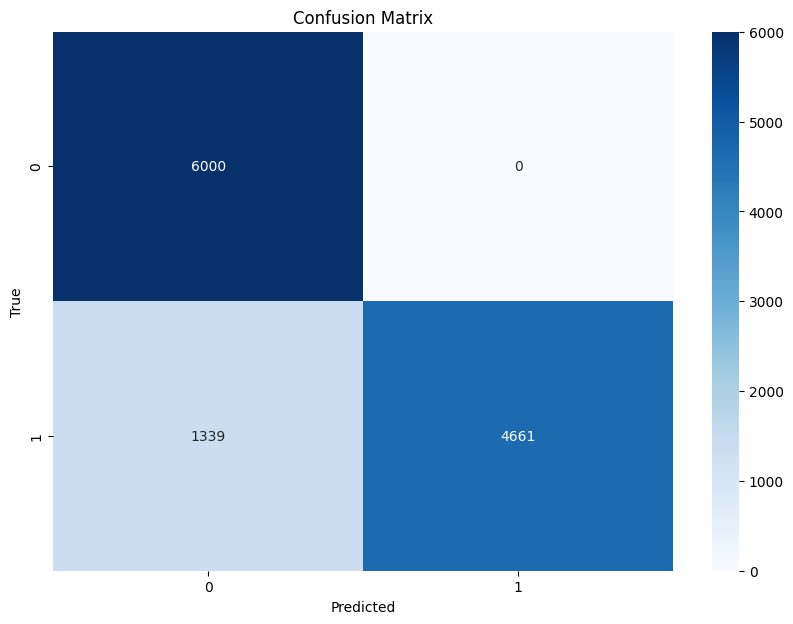

In [2]:
from utils import get_train_test, get_classification_report, plot_confusion_matrix
from GAN import Discriminator


folder = "inpainting"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)

,precision,recall,f1-score,support
0,0.493441,0.507833,0.500534,6000.00000
1,0.493047,0.478667,0.485751,6000.00000
accuracy,0.493250,0.493250,0.493250,0.49325
macro avg,0.493244,0.493250,0.493142,12000.00000
weighted avg,0.493244,0.493250,0.493142,12000.00000


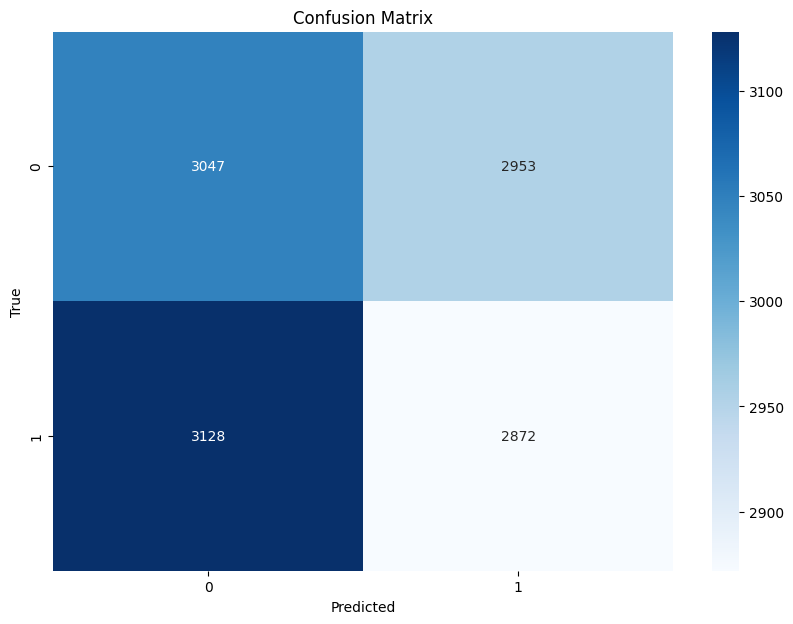

In [3]:
folder = "insight"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)


,precision,recall,f1-score,support
0,0.999665,0.993667,0.996657,6000.000000
1,0.993704,0.999667,0.996677,6000.000000
accuracy,0.996667,0.996667,0.996667,0.996667
macro avg,0.996685,0.996667,0.996667,12000.000000
weighted avg,0.996685,0.996667,0.996667,12000.000000


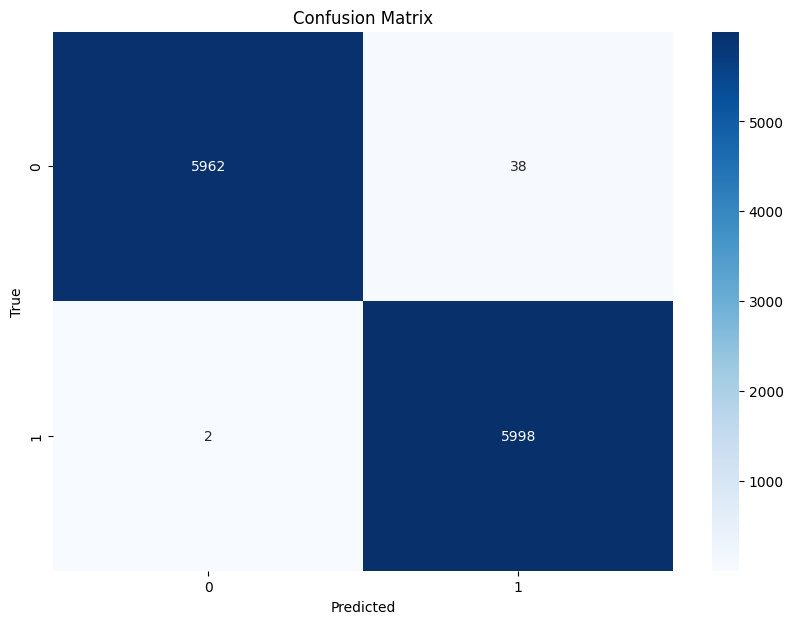

In [4]:
folder = "text2img"
_, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
discriminator = Discriminator.load(f"models/discriminator_{folder}.pth")
pred_df = discriminator.predict(test_df)
display(get_classification_report(pred_df))
plot_confusion_matrix(pred_df)

### Full discriminator

Results for inpainting folder


,precision,recall,f1-score,support
0,0.999165,0.997000,0.998081,6000.000000
1,0.997006,0.999167,0.998085,6000.000000
accuracy,0.998083,0.998083,0.998083,0.998083
macro avg,0.998086,0.998083,0.998083,12000.000000
weighted avg,0.998086,0.998083,0.998083,12000.000000


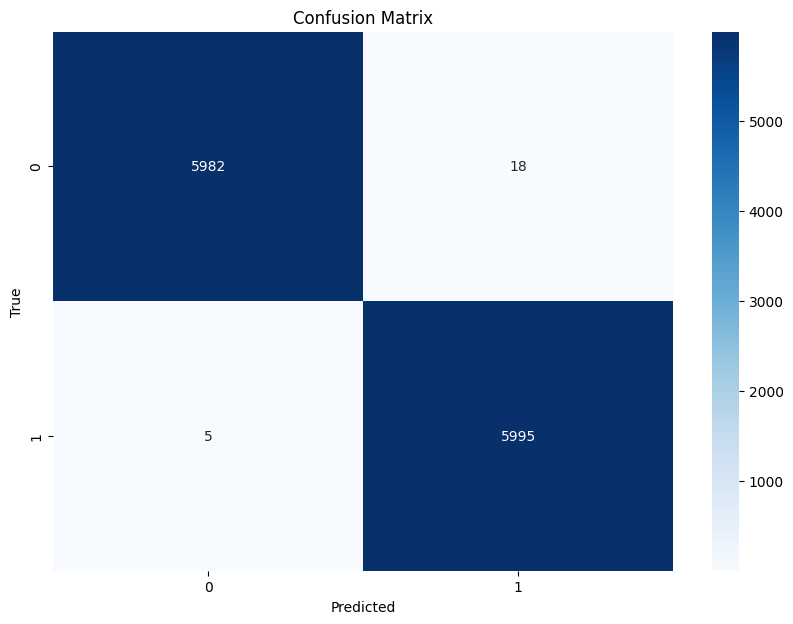

Results for insight folder


,precision,recall,f1-score,support
0,0.999156,0.986333,0.992703,6000.00000
1,0.986506,0.999167,0.992796,6000.00000
accuracy,0.992750,0.992750,0.992750,0.99275
macro avg,0.992831,0.992750,0.992750,12000.00000
weighted avg,0.992831,0.992750,0.992750,12000.00000


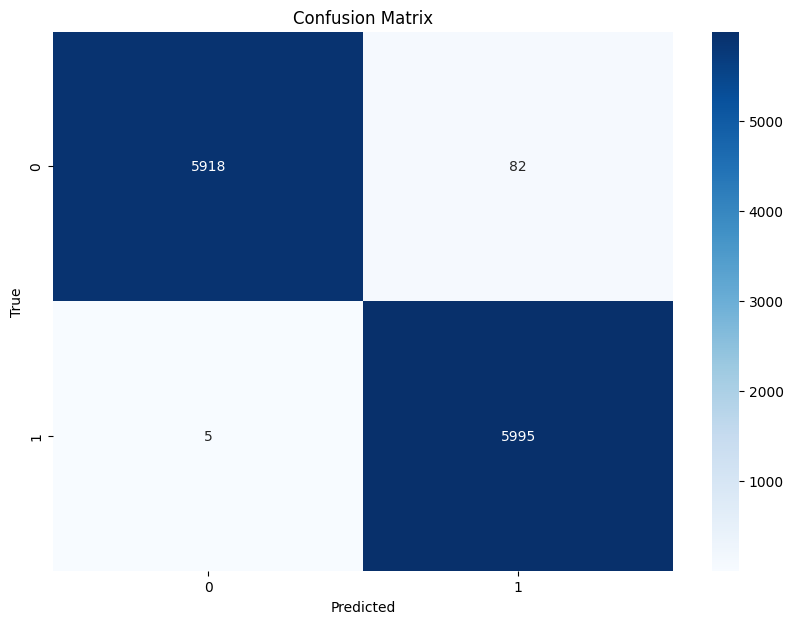

Results for text2img folder


,precision,recall,f1-score,support
0,0.999167,0.999667,0.999417,6000.000000
1,0.999666,0.999167,0.999417,6000.000000
accuracy,0.999417,0.999417,0.999417,0.999417
macro avg,0.999417,0.999417,0.999417,12000.000000
weighted avg,0.999417,0.999417,0.999417,12000.000000


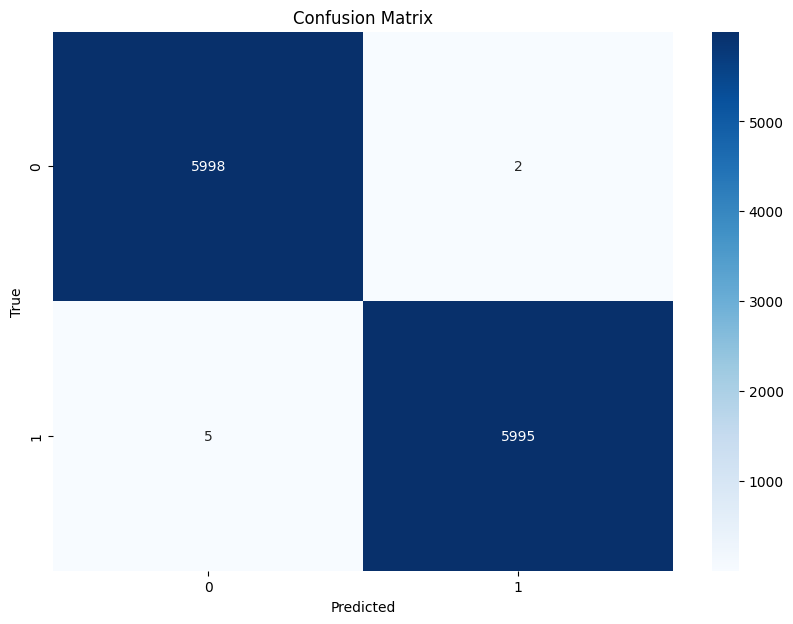

In [5]:
folders = ["inpainting", "insight", "text2img"]

discriminator = Discriminator.load(f"models/discriminator_full.pth")
for folder in folders:
    _, test_df = get_train_test(real="data/wiki/", fake=f"data/{folder}/")
    pred_df = discriminator.predict(test_df)
    print(f"Results for {folder} folder")
    display(get_classification_report(pred_df))
    plot_confusion_matrix(pred_df)

### Testing with a random image

In [ ]:
# Sample one image from test_df
sample = test_df.sample(1).iloc[0]
pred_label, pred_prob = discriminator.predict_single(sample['path'])

# Training a GAN to use the Generator after

```python
    df, _ = get_train_test(real="data/wiki/")

    gan = load_latest_gan()

    gan.fit(
        dataframe=df,
        batch_size=BATCH_SIZE//2,
        epochs=100,
        lr_gen=0.0002,
        lr_disc=0.00001,
        verbose=True
    )

    os.makedirs("models", exist_ok=True)
    gan.save("models/generator.pth")
```

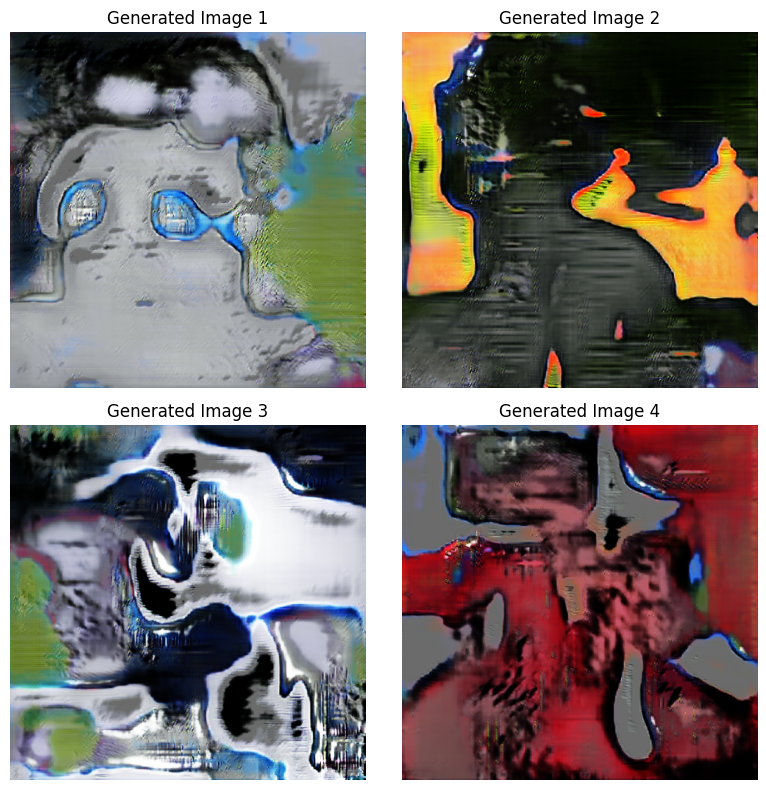

In [9]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from GAN import Generator

# Load saved Generator
generator = Generator.load("models/gan_epoch_87/generator.pth")

# Generate fake images
generated_images = generator.generate(num_images=4)

plt.figure(figsize=(8, 8))
for i, img_tensor in enumerate(generated_images):
    img = TF.to_pil_image((img_tensor.cpu() + 1) / 2)  # scale from [-1, 1] to [0, 1]
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Generated Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

